# Gather reports related to public health

## Import libraries

In [1]:
import json
import requests
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Set variables

In [2]:
BASE_URL = "https://api.figshare.com/v2"

In [3]:
categories = ["'Public Health and Health Services not elsewhere classified'","'Health Promotion'","'Public health not elsewhere classified'","'Health Policy'","'Health and Community Services'",
             "'Urban planning and health'","'Health and community services'","'Indigenous health'","'Health surveillance'","'Global Indigenous studies health and wellbeing'","'Community Child Health'",
             "'Community child health'"]



In [4]:
test = ["'Community child health'"]

In [7]:
#Gather basic metadata for items (articles) that meet your search criteria
results = []
for i in categories:
    query = '{"item_type": 18, "search_for":":category: ' + i + '"}' #Search for reports
    y = json.loads(query) #Figshare API requires json paramaters
    for j in range(1,10):
        records = json.loads(requests.post(BASE_URL + '/articles/search?page_size=1000&page={}'.format(j), params=y).content)
        results.extend(records)
    
#See the number of articles
print(len(results),'articles retrieved')

276 articles retrieved


In [8]:
#Save the json.
with open('pub-health-reports'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(results, f)

In [9]:
#Create a dataframe from the JSON formatted data
dfall = pd.DataFrame(results)

In [13]:
dfunique = dfall.drop_duplicates(subset='id', keep="first")
print(len(dfall)-len(dfunique),'records removed,',len(dfunique),'unique records remain')

50 records removed, 226 unique records remain


In [17]:
#Remove records that have a handle not a doi
nan_value = float("NaN")
dfuniquedoi = dfunique
dfuniquedoi.replace("", nan_value, inplace=True) #Replace blanks with nan
dfuniquedoi.dropna(subset = ["doi"])
print(len(dfunique)-len(dfuniquedoi),'records removed,',len(dfuniquedoi),'unique records remain')

0 records removed, 226 unique records remain


c:\users\andre.desktop-dfg3gu2\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [19]:
#Save a file of all the metadata
save_file = dfuniquedoi.to_csv('pub-health-reports-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

In [19]:
#Open a file if needed
dfuniquedoi = pd.read_csv('pub-health-reports-07-01.csv',encoding='utf8')

In [21]:
#Create a list of all the article ids
article_ids = dfuniquedoi['id'].tolist()

In [22]:
#article_ids2 = article_ids[12679:16047]
len(article_ids)

226

In [23]:
# Create a csv file, use an API to gather data, reopen the csv as a dataframe
   

#Create csv file
metadata=open('article-stats'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv', 'w', newline='')
#Write header row to csv
csv.writer(metadata).writerow(['id','views','downloads','shares'])            

            
for l in article_ids:
    s=requests.get('https://stats.figshare.com/total/views/article/'+ str(l),headers={"mailto":"andrew@figshare.com"})
    r=json.loads(s.text)
    t=requests.get('https://stats.figshare.com/total/downloads/article/'+ str(l),headers={"mailto":"andrew@figshare.com"})
    q=json.loads(t.text)
    u=requests.get('https://stats.figshare.com/total/shares/article/'+ str(l),headers={"mailto":"andrew@figshare.com"})
    v=json.loads(u.text)
    
    #write the values to the csv file. Dates in json files are seconds from jan 1 1970 so datetime.datetime.fromtimestamp converts
    csv.writer(metadata).writerow([
        l,
        r.get('totals'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'. However, metadata assessment counts non nulls
        q.get('totals'),
        v.get('totals')]) 
    
    
metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf8 error.
dfstats = pd.read_csv('article-stats'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv',encoding='utf8')

print('The resulting dataframe has',len(dfstats),'rows')

The resulting dataframe has 226 rows


In [13]:
dfstats = pd.read_csv('article-stats-all-2022-07-02.csv',encoding='utf8')

In [24]:
df_full1 = dfuniquedoi.merge(dfstats, how='left', on='id') #left to keep all records, the stats frame is missing 3

### Gather keyword, category, funder, license, number of files metadata

In [25]:
def exists(obj, chain):
    _key = chain.pop(0)
    if _key in obj:
        return exists(obj[_key], chain) if chain else obj[_key]

#-----------------------------Create csv files---------------------------------------
metadata=open('extra-metadata.csv', 'w', encoding='utf-8', newline='')
#Write header row to csv

csv.writer(metadata).writerow(['id','license','categories','tags','funders','count_references','count_files'])


for i in article_ids:
    record = json.loads(requests.get('https://api.figshare.com/v2/articles/' + str(i)).content)
    #Get publish date, title, categories
    #First get a list of category names and funder information from record
    cats = []
    for c in record['categories']:
        cats.append(c['title'])
    
    funders = [] #funder name might be duplicated across multiple grants for an item. Create a dictionary to deduplicate later
    for f in record['funding_list']:
        entry = {"id":i, "funder_name":f['funder_name']}
        funders.append(entry)

    
    #Then write to csv
    csv.writer(metadata).writerow([
                    i,
                    record['license']['name'],
                    cats,
                    record['tags'],
                    funders,
                    len(exists(record,['references'])) if exists(record,['references'])!=None else 0,
                    len(exists(record,['files'])) if exists(record,['files'])!=None else 0
                    ])


metadata.close() #Close the output file, release all locks


#Load file just created as a dataframe
metadata = pd.read_csv('extra-metadata.csv')


print(len(metadata),"records collected")



226 records collected


In [26]:
df_full = df_full1.merge(metadata, how='inner', on='id')

In [27]:
#Save the json.
with open('pub-health-reports-funding'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(funders, f)

In [28]:
#Save a file of all the metadata
save_file = df_full.to_csv('MASTER-pub-health-reports-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

## Analysis

In [22]:
#Open a file if needed
df_full = pd.read_csv('MASTER-humanities-metadata2022-07-05.csv',encoding='utf8')

In [58]:
len(df_full)

16048

In [60]:
missing_stats = df_full[df_full['views'].isna()]
missing_stats.head()

,Unnamed: 0,project_id,id,title,doi,handle,url,published_date,thumb,defined_type,...,resource_doi,views,downloads,shares,license,categories,tags,funders,count_references,count_files
8677,9399,NaN,13696192,Interview with Curtis Martin,10.15786/13696192.v3,NaN,https://api.figshare.com/v2/articles/13696192,2021-11-15T19:18:55Z,https://s3-eu-west-1.amazonaws.com/ppreviews-u...,2,...,NaN,NaN,NaN,NaN,CC BY 4.0,['History'],"['Western Wyoming Community College (1989- )',...",[],0,5
12678,17833,18224.0,4539143,Russian Wiktionary thesaurus in Gephi format (...,10.6084/m9.figshare.4539143.v1,NaN,https://api.figshare.com/v2/articles/4539143,2017-01-11T05:26:52Z,NaN,3,...,NaN,NaN,NaN,NaN,CC BY 4.0,"['Linguistics', 'Computer Graphics']","['thesaurus', 'Gephi', 'Wiktionary']","[{'id': 4539143, 'funder_name': None}]",0,1
16047,22373,NaN,4684120,Experience as a Catalyst for Healing Ministry:...,10.6084/m9.figshare.4684120.v1,NaN,https://api.figshare.com/v2/articles/4684120,2017-02-23T14:46:22Z,https://s3-eu-west-1.amazonaws.com/pfigshare-u...,14,...,NaN,NaN,NaN,NaN,CC BY 4.0,"['History', 'Religious Studies']","['F.F. Bosworth', 'William Branham', 'Miracles...",[],5,1


In [29]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   project_id         66 non-null     float64
 1   id                 226 non-null    int64  
 2   title              226 non-null    object 
 3   doi                195 non-null    object 
 4   handle             31 non-null     object 
 5   url                226 non-null    object 
 6   published_date     226 non-null    object 
 7   thumb              202 non-null    object 
 8   defined_type       226 non-null    int64  
 9   defined_type_name  226 non-null    object 
 10  group_id           226 non-null    int64  
 11  url_private_api    226 non-null    object 
 12  url_public_api     226 non-null    object 
 13  url_private_html   226 non-null    object 
 14  url_public_html    226 non-null    object 
 15  timeline           226 non-null    object 
 16  resource_title     18 non-

## Look at dates

In [31]:
with open("pub-health-reports2022-07-15.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    full_records = json.load(read_file)


In [32]:
#The dates are all contained within one column called 'timeline'. Flatten that column and associate the values
#with the proper article id in a new dataframe

temp_date_list = []

for item in full_records:
    dateitem = item['timeline']
    dateitem['id'] = item['id']
    dateitem['doi'] = item['doi']
    temp_date_list.append(dateitem)

df_dates = pd.json_normalize(
    temp_date_list 
)

#Have to de-duplicate and remove handles to match df_full
dfunique = df_dates.drop_duplicates(subset='id', keep="first")
#Remove records that have a handle not a doi
df_dates_full = dfunique[dfunique['doi'] != ""]


#Merge the dataframes
df_full = df_full.merge(df_dates_full, how='left', on='id')

print("Dates split out and merged,",len(df_full),'records in dataframe')

Dates split out and merged, 226 records in dataframe


In [33]:
post_dates = df_full['posted'].tolist()
post_dates.sort()
first_date = post_dates[0]
last_date = post_dates[-1]
print('Earliest date:',first_date,'; Most recent date:',last_date)

TypeError: '<' not supported between instances of 'float' and 'str'

In [67]:
online_dates = df_full['firstOnline'].tolist()
online_dates.sort()
first_date = online_dates[0]
last_date = online_dates[-1]
print('Earliest date:',first_date,'; Most recent date:',last_date)

Earliest date: 1960-01-01T00:00:00 ; Most recent date: 2022-07-01T04:15:04


In [68]:
pub_dates = df_full['published_date'].tolist()
pub_dates.sort()
first_date = pub_dates[0]
last_date = pub_dates[-1]
print('Earliest date:',first_date,'; Most recent date:',last_date)

Earliest date: 1970-01-01T00:00:00Z ; Most recent date: 2022-07-01T12:12:59Z


In [34]:
#Look at item type list
df_full['defined_type_name'].value_counts()

report    226
Name: defined_type_name, dtype: int64

In [35]:
#Look at item type list
df_full['license'].value_counts()

In Copyright                    59
CC BY 4.0                       56
CC BY-NC-SA 4.0                 37
CQUniversity General 1.0        25
CC BY-NC-ND 4.0                 20
CC BY-ND 4.0                     8
CC BY-NC 4.0                     8
CQUniversity Open Access 1.0     7
CC BY-SA 4.0                     3
Public Domain                    1
All Rights Reserved 1.0          1
CC BY 3.0                        1
Name: license, dtype: int64

In [36]:
#Replace the [] with NaN
df_full['funders'].replace('[]', np.NaN, inplace = True)


In [37]:
#Count links to funder (this is not just a funder listed, its the name of a funder from Dimensions)
df_full['funders'].count()

142

In [38]:
mean_files = df_full['count_files'].mean()
mean_files

1.261061946902655

In [78]:
#Number of records with 1 or fewer files
print(len(df_full[df_full['count_files'] <= 1]),'records with one or fewer files;',
      len(df_full[df_full['count_files'] == 0]),'with zero files;',
      len(df_full[df_full['count_files'] > 1]),'filesets')

      

13350 records with one or fewer files; 4952 with zero files; 2698 filesets


<ipython-input-39-fa608e74ad89>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize = 12)


[Text(0, 0.0, '0.0'),
 Text(0, 10.0, '10.0'),
 Text(0, 20.0, '20.0'),
 Text(0, 30.0, '30.0'),
 Text(0, 40.0, '40.0'),
 Text(0, 50.0, '50.0'),
 Text(0, 60.0, '60.0'),
 Text(0, 70.0, '70.0'),
 Text(0, 80.0, '80.0')]

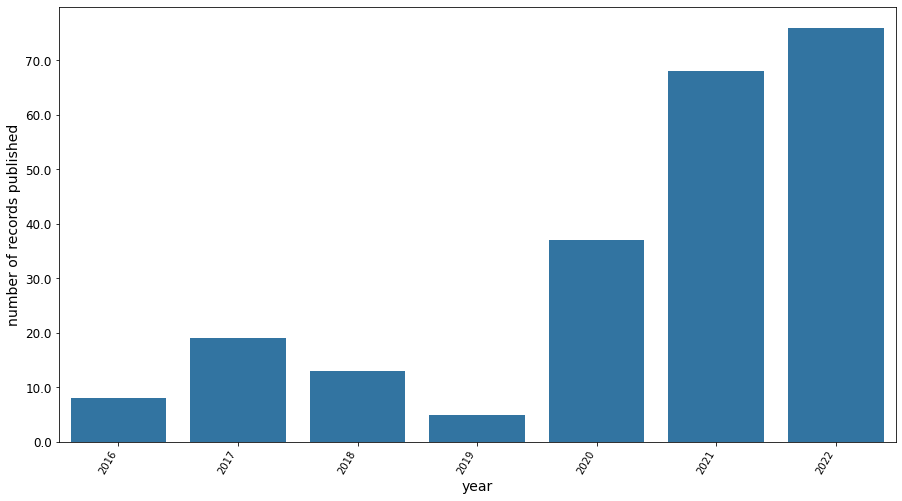

In [39]:
#Split the year out and add it as a column
year = df_full["published_date"].str.split("-", n = 1, expand = True)
df_full['year'] = year[0]

#Group by year
datechart = df_full.groupby(['year']).count().reset_index()

#Chart it all out
#sns.color_palette("husl", 8)
plt.rcParams["figure.figsize"] = (15,8)
ax = sns.barplot(data=datechart, x="year", y="id", palette=["C0"])
#ax.set(xlabel='year', ylabel='number of records published')
ax.set_ylabel("number of records published", fontsize = 14)
ax.set_xlabel("year", fontsize = 14)
ax.set_xticklabels(datechart['year'], fontsize = 10, rotation=60, ha="right")
ax.set_yticklabels(ax.get_yticks(), fontsize = 12)

In [80]:
tags = df_full['tags'].to_frame()

#Clean up the strings so each value is words separated by commas and a space
tags['tags_clean'] = tags['tags'].str.replace('[','', regex=False)
tags['tags_clean'] = tags['tags_clean'].str.replace(']','', regex=False)
tags['tags_clean'] = tags['tags_clean'].str.replace("'","", regex=False)

#Create a list to hold the list of words for each row, the tags are added to the sublists based on the ', '
tags_clean = []
for y in tags['tags_clean']:
    value = y.split(', ')
    tags_clean.append(value)

#Make the list of lists to one list:
all_tags = [word for tag in tags_clean for word in tag]
len(all_tags)

67605

In [81]:
all_tags_df = pd.DataFrame(all_tags, columns = ['tag'])
tops = all_tags_df.value_counts()

In [82]:
tops.head(20)

tag                                       
Philosophy                                    499
Photography                                   316
Stereoscopic                                  297
Yellowstone National Park                     297
Wyoming                                       297
S00033                                        252
S00050                                        229
Oral history                                  225
S00036                                        201
S00060                                        182
Oral tradition                                164
Western Wyoming Community College (1989- )    164
digital humanities                            144
S00020                                        139
S00008                                        138
S00030                                        105
S00518                                        102
History                                        95
history                                        94
Bioethi

In [40]:
#How many records are on figshare.com, that is, don't have a group_id
test = df_full['group_id'].isna().sum()
test

0